In [1]:
import sys

In [17]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")
import torch
from nwnTorch.misc import *
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

In [3]:
class Reservoir():
    # def __init__(self,N=3,Dr=300, rho=1,delta=0.1,b=0,transient=1000,R_network=None,W_in=None):

    def __init__(self, N, W_net = None, W_in = None):
        self.params = {
            "delta": 0.1,
            "b"    : 0,
                       }
        
        self.N           = N
        self.W_net       = W_net
        self.W_in        = W_in
        self.R           = torch.zeros(N)
        self.initialized = False
    
    def _run_step(self, data):
        assert self.N == self.W_net.shape[0] == self.W_net.shape[1] == self.W_in.shape[0]
        # assert self.W_in.shape[1] == data.shape
        self.R = torch.tanh(
            self.W_net @ self.R + \
            self.params["delta"] * self.W_in @ data + \
            self.params["b"]
        )

In [4]:
data = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/pair_0.pkl")
X,Y = data

In [5]:
# N                = 1000
N   = 1000
G   = nx.erdos_renyi_graph(n = N, p = 0.2)
adj = torch.tensor(nx.adjacency_matrix(G).todense())

W_net = (torch.rand(N,N) * 2 - 1) * adj
# W_net            = torch.rand(N,N) * 2 - 1
W_in             = torch.rand(N,1)
rnet             = Reservoir(N, W_net=W_net, W_in=10*W_in)
rnet.params["b"] = 0.5

rnet_rec = torch.zeros(3000,N)

for i in range(3000):
    rnet._run_step(X[[i]])
    rnet_rec[i] = rnet.R

In [6]:
# lhs = rnet_rec[-2000:,:]
# lhs = torch.hstack((torch.ones(2000,1), rnet_rec[-2000:]))
lhs = torch.hstack((X[-2000:].reshape(-1,1), rnet_rec[-2000:]))
rhs = Y[-2000:]

weight, result, rcond = best_regress(lhs, rhs)
predict = weight @ lhs.T

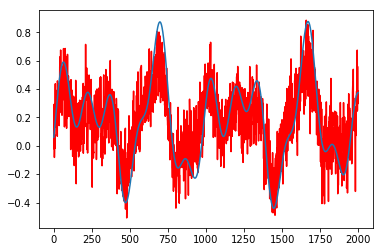

In [7]:
# plt.scatter(range(2000), predict, s = 1, c = "r")
plt.plot(range(2000), predict, c = "r")

plt.plot(Y[-2000:])

In [8]:
get_MSE(predict, Y[-2000:])

tensor(0.0376)

In [9]:
def MC_k(readout, target,
         tau = 1, T0 = 0, L = 1000):
    
    pick = torch.arange(T0,T0+L)
    lhs  = readout[pick+tau]
    rhs  = target[pick]

    weight, result, rcond = best_regress(lhs, rhs)
    predict = weight @ lhs.T
    mc      = torch.cov(torch.vstack((predict, rhs)))[0,1]**2 / \
                (torch.var(predict) * torch.var(rhs))

    return mc

In [23]:
def calc_MC(readout, target, 
            tau = 1, T0 = 0, L = 1000):
    pick        = torch.arange(T0,T0+L)
    readout_tau = readout[pick+tau]
    target_tau  = target[pick]
    weight, result, rcond = best_regress(readout_tau, target_tau)

    predict = weight @ readout_tau.T
#     mc      = torch.cov(torch.vstack((predict, target_tau)))[0,1]**2 / \
                # (torch.var(predict) * torch.var(target_tau))
    mc      = torch.cov(torch.vstack((predict, target_tau)))[0,1]**2 / \
                (torch.var(predict) * torch.var(target[pick+tau]))
    # mc = torch.corrcoef(torch.stack((predict, target_tau)))[0,1]**2

    return mc

In [24]:
torch.random.manual_seed(0)
N     = 300
G     = nx.erdos_renyi_graph(n = N, p = 0.2)
adj   = torch.tensor(nx.adjacency_matrix(G).todense())
W_net = (torch.rand(N,N) * 2 - 1) * adj
W_in  = torch.rand(N,1) * 1
rnet  = Reservoir(N, W_net=W_net, W_in=W_in)

rnet.params["b"] = 0
rnet.params["delta"] = 0.5


sig      = torch.rand(3000) * 2 -1
# sig = X
rnet_rec = torch.zeros(3000,N)

for i in range(3000):
    rnet._run_step(sig[[i]])
    rnet_rec[i] = rnet.R

In [25]:
MC = torch.zeros(N)
for i in tqdm(range(1,N+1)):
    MC[i-1] = calc_MC(rnet_rec, sig, i, 500, 1000)

100%|██████████| 300/300 [00:12<00:00, 23.82it/s]


tensor(89.4624)

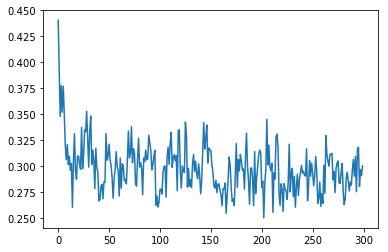

In [26]:
plt.plot(MC)
torch.sum(MC)